# Nuclear quadrupole interaction in $\text{CH}_2^{35}\text{Cl}^{37}\text{Cl}$

Calculate rotational hyperfine energies and spectrum of the asymmetric isotopologue $\text{CH}_2^{35}\text{Cl}^{37}\text{Cl}$, including the nuclear quadrupole interaction arising from the nuclear quadrupole couplings of the two chlorine nuclei.

Each chlorine nucleus has a nuclear spin of $I = \tfrac{3}{2}$, with nuclear quadrupole moments of $Q(^{35}\text{Cl}) = -81.65$ mb and $Q(^{37}\text{Cl}) = -64.35$ mb [Pyykkö], and magnetic dipoles of $\mu(^{35}\text{Cl}) = 0.8218743$ and $\mu(^{37}\text{Cl})=0.6841236$ (in units of nuclear magneton) [Stone].

The molecular geometry, dipole moment, and electric field gradient tensors (EFG) used in this simulation are defined in the module [ch2cl2_cc.py](ch2cl2_cc.py) (or [ch2cl2_dft.py](ch2cl2_dft.py)).
The effective-Hamiltonian constants for the pure rotational solutions are taken from [Ulenikov].

References:
- [Pyykkö] Pyykkö, Year-2008 Nuclear Quadrupole Moments, Mol. Phys. 106 (2008) 1965, DOI: http://dx.doi.org/10.1080/00268970802018367
- [Stone] Stone, Table of Nuclear Magnetic Dipole and Electric Quadrupole Moments, At. Data Nucl. Data Tables. 90 (2005) 75, DOI: https://doi.org/10.1016/j.adt.2005.04.00
- [Ulenikov] Ulenikov, Gromova, Bekhtereva, Müller, Margulès, Submillimeter wave spectrum of methylene chloride $^{12}\text{CH}_2^{35}\text{Cl}_2$, $^{12}\text{CH}_2^{35}\text{Cl}^{37}\text{Cl}$ and $^{12}\text{CH}_2^{37}\text{Cl}_2$ up to 1.1 THz, J. Quant. Spectrosc. Radiat. Transf. 319 (2024) 108962, DOI: https://doi.org/10.1016/j.jqsrt.2024.108962

In [2]:
import sys

sys.path.append("../utils")

import ch2cl2_cc as ch2cl2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter, MaxNLocator
from plot_dens import plot_mc_dens, plot_mc_spin_dens
from richmol import (
    CartTensor,
    HyperCartTensor,
    HyperStates,
    QuadMom,
    RotStates,
    Spin1Tensor,
)
from richmol.asymtop import com, inertia_tensor, rotational_constants, write_xyz
from scipy import constants
from scipy.sparse import csr_array

plt.rcParams.update(
    {"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern"]}
)

Rotate *ab initio* calculated geometry, dipole moment, polarizability, and EFG tensors to the principal axes system (PAS).

In [6]:
# Rotate Cartesian coordinates and tensors to principal axes system (PAS)

atom_masses = ch2cl2.atom_masses_35_37
atom_labels = ch2cl2.atom_labels_35_37

(A, B, C), v = rotational_constants(atom_masses, ch2cl2.atom_xyz)
kappa = (2 * B - A - C) / (A - C)
print("A, B, C (cm^-1):", A, B, C)
print("A, B, C (MHz):", *(elem * constants.c * 1e-4 for elem in (A, B, C)))
print("kappa:", kappa)
if kappa < 0:
    print("prolate top")
    perm_mat = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]])
else:
    print("oblate top")
    perm_mat = np.eye(3)

pas = perm_mat @ v.T

atom_xyz = (ch2cl2.atom_xyz - com(atom_masses, ch2cl2.atom_xyz)) @ pas.T
write_xyz("ch2cl2_35_37_pas_coords.xyz", atom_labels, atom_xyz)

# check that inertia tensor is diagonal in PAS
imom = inertia_tensor(atom_masses, atom_xyz)
print(
    "Inertia tensor diagonal?:",
    np.allclose(imom, np.diag(np.diagonal(imom)), atol=1e-12),
)

dip_mol = pas @ np.array(ch2cl2.dip_mol)
efg_mol_cl1 = pas @ np.array(ch2cl2.efg_mol_cl1) @ pas.T
efg_mol_cl2 = pas @ np.array(ch2cl2.efg_mol_cl2) @ pas.T

print("Dipole moment in PAS:\n", dip_mol)
print("EFG on Cl1 in PAS:\n", efg_mol_cl1)
print("EFG on Cl2 in PAS:\n", efg_mol_cl2)

print("EFG(Cl1) - EFG(Cl2) (diag):\n", np.diag(efg_mol_cl1 - efg_mol_cl2))

A, B, C (cm^-1): 1.0611509669119346 0.10658589173989354 0.09870483774896069
A, B, C (MHz): 31812.505667960555 3195.3646472824585 2959.0965925252117
kappa: -0.983622867291727
prolate top
Inertia tensor diagonal?: True
Dipole moment in PAS:
 [0.64539155 0.         0.00234936]
EFG on Cl1 in PAS:
 [[-0.09597223  0.         -2.48900259]
 [ 0.         -1.92579536  0.        ]
 [-2.48900259  0.          2.02176759]]
EFG on Cl2 in PAS:
 [[-0.13210049  0.          2.47332133]
 [ 0.         -1.92579536  0.        ]
 [ 2.47332133  0.          2.05789585]]
EFG(Cl1) - EFG(Cl2) (diag):
 [ 0.03612826  0.         -0.03612826]


In [7]:
# print(" & ".join("%7.3f"% elem for elem in efg_mol_cl1[np.triu_indices(3)]))
# print(" & ".join("%7.3f"% elem for elem in efg_mol_cl2[np.triu_indices(3)]))

Plot the molecule and orientation of PAS axes.

<img src="ch2cl2_35_37_pas_coords.png" alt="" width="300"/>

Using the orientation of the $x,y,z$ axes in the PAS frame, as shown on the figure above, derive the symmetry equivalent rotations:

- $(12)^*$ is equivalent to $180^\circ$-rotation about the $y$-axis, $R_{\pi/2}^\pi$

The corresponding character vectors for the irreps are:
- Symmetry $\text{A}$: [1, 1]
- Symmetry $\text{B}$: [1, -1]

Compute rotational states using effective-Hamiltonian approach with rotational constants from [Ulenikov].

In [8]:
# rotational constants from Table 5, 'Our fit', in [Ulenikov]
inp_ulenikov = (
    "A/MHz",       31878.73862,
    "B/MHz",        3231.155548,
    "C/MHz",        2988.024042,
    "DeltaK/kHz",    469.41612,
    "DeltaJK/kHz",   -25.486368,
    "DeltaJ/kHz",      1.3271702,
    "deltaK/kHz",      5.16939,
    "deltaJ/kHz",      0.16502018,
)

jmax = 20
states = RotStates.watson(
    jmax,
    inp_ulenikov,
    print_enr=True,
)

dip_lab = CartTensor(states, dip_mol)
efg_lab_cl1 = CartTensor(states, efg_mol_cl1)
efg_lab_cl2 = CartTensor(states, efg_mol_cl2)


Compute rotational solutions using Watson's effective Hamiltonian approach
Input rotational constants (MHz):
          A 31878.738620000000 
          B  3231.155548000000 
          C  2988.024042000000 
     DeltaK     0.469416120000 
    DeltaJK    -0.025486368000 
     DeltaJ     0.001327170200 
     deltaK     0.005169390000 
     deltaJ     0.000165020180 
Watson reduction form: A
Axes convention for near-prolate: I(r), xyz = bca
Remark: manually apply permutation (132) to other input Cartesian tensors (like dipole moment) in the PAS frame,
   e.g., using permutation matrix np.array([[0,1,0],[0,0,1],[1,0,0]])
solve for J = 0 and symmetry A ...
number of functions: 1
Axes convention for near-prolate: I(r), xyz = bca
Remark: manually apply permutation (132) to other input Cartesian tensors (like dipole moment) in the PAS frame,
   e.g., using permutation matrix np.array([[0,1,0],[0,0,1],[1,0,0]])
solve for J = 1 and symmetry A ...
number of functions: 3
Axes convention for near-pr

We can also compute rotational states using rigid-rotor Hamiltonian, defined by geometry of the molecule computed *ab initio*.
This will override rotational states and lab-frame matrix elements generated in the previous cell using effective-Hamiltonian approach.
Skip this cell if want to employ effective Hamiltonian for rotational solutions.

In [9]:
# Compute rotational states and matrix elements of laboratory-frame tensors

# xyz = [[atom, *xyz] for atom, xyz in zip(atom_labels, atom_xyz)]
# xyz = [el for elem in xyz for el in elem]

# jmax = 20
# states = RotStates.from_geometry(
#     jmax,
#     xyz,
#     print_enr=True,
# )

# dip_lab = CartTensor(states, dip_mol)
# efg_lab_cl1 = CartTensor(states, efg_mol_cl1)
# efg_lab_cl2 = CartTensor(states, efg_mol_cl2)

Compute hyperfine states using rotational states, ab initio calculated EFG tensors, and quadrupole moments from [Pyykkö].

In [10]:
# Compute hyperfine states and matrix elements of laboratory-frame tensors

# quadrupole moments (in mb) from [Pyykkö]
quad_cl35 = QuadMom(spin=3 / 2, Q=-81.65)
quad_cl37 = QuadMom(spin=3 / 2, Q=-64.35)

hyper_states = HyperStates(
    0,
    jmax - 3,
    states,
    spin_op=[quad_cl35, quad_cl37],
    efg_op=[efg_lab_cl1, efg_lab_cl2],
)

hyper_dip_lab = HyperCartTensor(hyper_states, dip_lab)
spin_tens1 = Spin1Tensor(0, hyper_states)
spin_tens2 = Spin1Tensor(1, hyper_states)


Compute hyperfine states
List of F quanta: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0)]
F   tot.sym.   J   (I_1, I_12, ... I_1N)     rovib.sym.   spin.sym.  rovib.dim 
----------------------------------------------------------------------------
0.0 A          0   (1.5, 0)                  A            A          1         
0.0 A          1   (1.5, 1)                  A            A          3         
0.0 A          2   (1.5, 2)                  A            A          5         
0.0 A          3   (1.5, 3)                  A            A          7         
1.0 A          1   (1.5, 0)                  A            A          3         
1.0 A          0   (1.5, 1)                  A            A          1         
1.0 

Print hyperfine states and assignments, the weights of *ortho* and *para* contributions.

In [16]:
# zero-point energy
zpe = np.min(
    [
        np.min(enr_sym)
        for enr_f in hyper_states.enr.values()
        for enr_sym in enr_f.values()
    ]
)

enr = []
for f in hyper_states.enr.keys():
    for sym in hyper_states.enr[f].keys():

        # extract (J, k, tau, I, F) quanta
        quanta = hyper_states.quanta_dict_k[f][sym]
        j_k_tau_i_f = [
            (*elem[6:9], elem[3], float(elem[0]), sym)
            for elem in hyper_states.quanta_dict_k[f][sym]
        ]

        # p(I) = \sum_i |c_i|^2 for spin I=0,1,2,3
        op_quanta = hyper_states.quanta_dict_op[f][sym]
        # for i in range(len(op_quanta)):
        #     print(f, sym, hyper_states.enr[f][sym][i], i, op_quanta[i])

        # compute p(para) = \sum_i |c_i|^2 for spin in (0, 2)
        #     and p(ortho) = \sum_i |c_i|^2 for spin in (1, 3)
        para_coef = [sum(c for (q, c) in qua if int(q) in (0, 2)) for qua in op_quanta]
        ortho_coef = [sum(c for (q, c) in qua if int(q) in (1, 3)) for qua in op_quanta]

        # assemble (J, k, tau, I, F, energy-zpe, p(para), p(ortho))
        enr += [
            (*q, float(e - zpe), pc, oc, ind)
            for ind, (q, e, pc, oc) in enumerate(
                zip(j_k_tau_i_f, hyper_states.enr[f][sym], para_coef, ortho_coef)
            )
        ]


# sort wrt energy
enr = sorted(enr, key=lambda elem: elem[6])


print(
    f"{'J':>2} {'k':>2} {'tau':>1} {'I':>1} {'F':>2} {'Energy':>16} {'w_para':>10} {'w_ortho':>10}"
)
for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    if f > 10:
        continue
    print(
        f"{j:2d}",
        f"{k:2d}",
        f"{tau:2d}",
        f"{int(spin):2d}",
        f"{int(f):2d}",
        f"{e:16.8f}",
        f"{p_c:10.8f}",
        f"{o_c:10.8f}",
    )

 J  k tau I  F           Energy     w_para    w_ortho
 0  0  0  0  0       0.00000000 1.00000000 0.00000000
 0  0  0  1  1       0.00162624 0.00000011 0.99999989
 0  0  0  3  3       0.00162625 0.00000011 0.99999989
 0  0  0  2  2       0.00325249 0.99999977 0.00000023
 1  0  1  1  0    6205.20410771 0.00000007 0.99999993
 1  0  1  2  1    6208.09318740 0.99797057 0.00202943
 1  0  1  3  3    6208.64108194 0.00527265 0.99472735
 1  0  1  1  2    6213.23309106 0.03197560 0.96802440
 1  0  1  2  3    6219.23478129 0.99472727 0.00527273
 1  0  1  2  2    6219.31251249 0.96335768 0.03664232
 1  0  1  3  4    6222.67642844 0.00000008 0.99999992
 1  0  1  1  1    6226.04936151 0.03832297 0.96167703
 1  0  1  2  1    6230.39296532 0.96370639 0.03629361
 1  0  1  3  2    6231.98523777 0.00466671 0.99533329
 2  0  0  3  3   18645.89160720 0.00359170 0.99640830
 2  0  0  2  2   18646.53866764 0.99714651 0.00285349
 2  0  0  3  4   18648.34302518 0.01291806 0.98708194
 2  0  0  1  1   18648.68164

Plot *para* (*ortho*) weights for states as function of their energy.

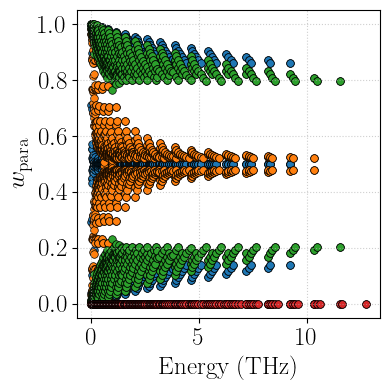

In [20]:
e_j = {}
for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    try:
        e_j[abs(f - j)].append((e, p_c))
    except KeyError:
        e_j[abs(f - j)] = [(e, p_c)]

fig = plt.figure(figsize=(4, 4), dpi=100)

colors = {0.0: "tab:blue", 1.0: "tab:orange", 2.0: "tab:green", 3.0: "tab:red"}

for key in sorted(list(e_j.keys())):
    e, p = np.array(e_j[key]).T
    plt.scatter(
        e / 1e6 if hyper_states.enr_units == "mhz" else e,
        p,
        marker="o",
        label=f"{int(key)}",
        s=30,
        facecolors=colors[key],
        edgecolors="black",
        linewidth=0.5,
    )

plt.grid(True, linestyle=":", alpha=0.6)
plt.tick_params(axis="both", labelsize=18)
if hyper_states.enr_units == "mhz":
    plt.xlabel("Energy (THz)", fontsize=18)
else:
    plt.xlabel("Energy (cm$^{-1}$)", fontsize=18)
plt.ylabel("$w_{\\rm para}$", fontsize=18)
# plt.legend(fontsize=16, title_fontsize=16, loc="upper right", title="$|F-J|$")
plt.tight_layout()
plt.savefig(f"ch2cl2_35_37_op_diagram.pdf", format="pdf", bbox_inches="tight")

Same plot as above, color-coded wrt $k$.

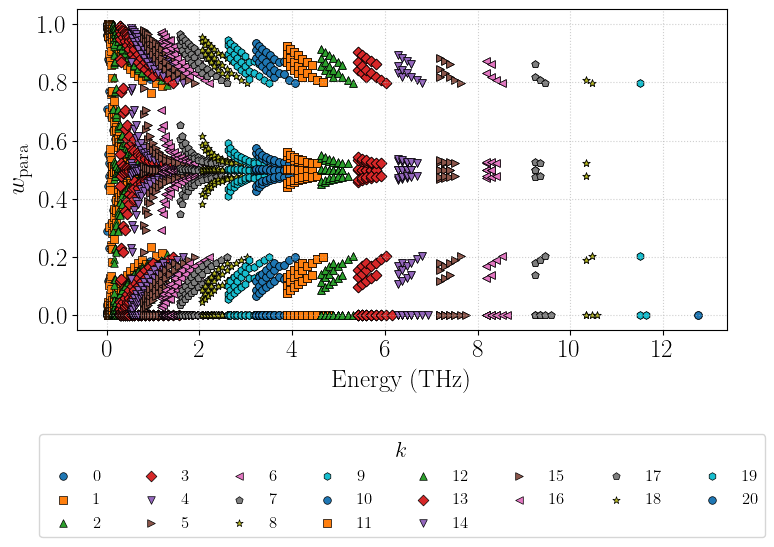

In [21]:
e_j = {}
for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    try:
        e_j[k].append((e, p_c))
    except KeyError:
        e_j[k] = [(e, p_c)]

fig = plt.figure(figsize=(8, 6), dpi=100)

markers = ["o", "s", "^", "D", "v", ">", "<", "p", "*", "h"]

for i, key in enumerate(sorted(list(e_j.keys()))):
    e, p = np.array(e_j[key]).T
    plt.scatter(
        e / 1e6 if hyper_states.enr_units == "mhz" else e,
        p,
        marker=markers[i % len(markers)],
        label=f"{int(key)}",
        s=30,
        edgecolors="black",
        linewidth=0.5,
    )

plt.grid(True, linestyle=":", alpha=0.6)
plt.tick_params(axis="both", labelsize=18)
if hyper_states.enr_units == "mhz":
    plt.xlabel("Energy (THz)", fontsize=18)
else:
    plt.xlabel("Energy (cm$^{-1}$)", fontsize=18)
plt.ylabel("$w_{\\rm para}$", fontsize=18)
plt.legend(
    fontsize=12,
    title_fontsize=16,
    ncol=8,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.3),
    title="$k$",
)
plt.tight_layout()

Compute expectation values of nuclear spin operators for selected states.

In [33]:
# Returns matrix elements of a selected Cartesian component of nuclear spin operators
def spin_me(cart_comp: str, f1, sym1, m1, ind1, f2, sym2, m2, ind2):
    m_ind1 = np.where(np.arange(-f1, f1 + 1) == m1)[0][0]
    m_ind2 = np.where(np.arange(-f2, f2 + 1) == m2)[0][0]
    try:
        mmat1 = spin_tens1.mmat[(f1, f2)][cart_comp][1].toarray()[m_ind1, m_ind2]
        kmat1 = spin_tens1.kmat[(f1, f2)][(sym1, sym2)][1].toarray()[ind1, ind2]
        mmat2 = spin_tens2.mmat[(f1, f2)][cart_comp][1].toarray()[m_ind1, m_ind2]
        kmat2 = spin_tens2.kmat[(f1, f2)][(sym1, sym2)][1].toarray()[ind1, ind2]
        return kmat1 * mmat1, kmat2 * mmat2
    except KeyError:
        return 0, 0


# Returns matrix elements of a selected Cartesian component of electric dipole moment
def dip_me(cart_comp: str, f1, sym1, m1, ind1, f2, sym2, m2, ind2):
    m_ind1 = np.where(np.arange(-f1, f1 + 1) == m1)[0][0]
    m_ind2 = np.where(np.arange(-f2, f2 + 1) == m2)[0][0]
    try:
        mmat = hyper_dip_lab.mmat[(f1, f2)][cart_comp][1].toarray()[m_ind1, m_ind2]
        kmat = hyper_dip_lab.kmat[(f1, f2)][(sym1, sym2)][1].toarray()[ind1, ind2]
        return kmat * mmat
    except KeyError:
        return 0

In [77]:
print(
    f"{'j':>3} {'k':>3} {'tau':>4} {'I':>4} {'F':>4} {'ind':>6} {'E (MHz)':>14} {'|F - J|':>7} {'w_para':>7} {'w_ortho':>7} "
    f"{'<I_z1>':>10} {'<I_z2>':>10}"
)

cart_comp = "z"

for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    m = f
    if k==10 and j in (10,):  # select k and J

        spin_me1, spin_me2 = spin_me(cart_comp, f, sym, m, ind, f, sym, m, ind)
        eTHz = round(e / 1e6, 6)
        eMHz = round(e, 4)

        print(
            f"{j:3} {k:3} {tau:4} {spin:4} {f:4} {ind:6} {eMHz:14.4f} {abs(j - f):7.1f} {p_c:7.1f} {o_c:7.1f} "
            f"{spin_me1.real:10.3f} {spin_me2.real:10.3f}"
        )

        # print(
        #     f"{j:3} & {k:3} & {tau:4} & {round(spin):4} & {round(f):4} & {eMHz:14.4f} & {p_c:6.2f} & {o_c:6.2f} & {spin_me1.real:10.3f} & {spin_me2.real:10.3f} \\\\"
        # )

  j   k  tau    I    F    ind        E (MHz) |F - J|  w_para w_ortho     <I_z1>     <I_z2>
 10  10    0  3.0  7.0    238   3214525.1465     3.0     0.0     1.0     -1.312     -1.312
 10  10    1  3.0  7.0    239   3214525.1465     3.0     0.0     1.0     -1.312     -1.312
 10  10    0  1.0 10.0    296   3214527.2361     0.0     0.5     0.5     -1.357      1.496
 10  10    1  1.0 10.0    297   3214527.2361     0.0     0.5     0.5     -1.357      1.496
 10  10    1  1.0 10.0    298   3214527.7134     0.0     0.5     0.5      1.494     -1.359
 10  10    0  1.0 10.0    299   3214527.7134     0.0     0.5     0.5      1.494     -1.359
 10  10    0  3.0 13.0    304   3214529.4971     3.0     0.0     1.0      1.500      1.500
 10  10    1  3.0 13.0    305   3214529.4971     3.0     0.0     1.0      1.500      1.500
 10  10    0  3.0  8.0    264   3214537.3502     2.0     0.1     0.9     -1.032     -0.442
 10  10    1  3.0  8.0    265   3214537.3502     2.0     0.1     0.9     -1.032     -0.442

Compute transition moments ror selected pairs of states with different orientations of nuclear spins.

In [95]:
f_sym_id_pairs = [
    (2.0, "A", 40, 2.0, "A", 42),
    (2.0, "A", 40, 2.0, "A", 43),
    (2.0, "A", 41, 2.0, "A", 42),
    (2.0, "A", 41, 2.0, "A", 43),
    #
    (3.0, "A", 25, 3.0, "A", 26),
    (3.0, "A", 25, 3.0, "A", 30),
    (3.0, "A", 29, 3.0, "A", 26),
    (3.0, "A", 29, 3.0, "A", 30),
    #
    (10.0, "A", 296, 10.0, "A", 298),
    (10.0, "A", 296, 10.0, "A", 299),
    (10.0, "A", 297, 10.0, "A", 298),
    (10.0, "A", 297, 10.0, "A", 299),
]

print(
    f"{'j1':>3} {'k1':>3} {'tau1':>4} {'I1':>4} {'F1':>4} {'E1 (MHz)':>14} {'<I_z1>':>7} {'<I_z2>':>7}      "
    f"{'j2':>3} {'k2':>3} {'tau2':>4} {'I2':>4} {'F2':>4} {'E2 (MHz)':>14} {'<I_z1>':>7} {'<I_z2>':>7} "
    f"{'<1|mu_z|2>':>13} {'<1|I_z1|2>':>11} {'<1|I_z2|2>':>11}"
)

for f1, sym1, ind1, f2, sym2, ind2 in f_sym_id_pairs:
    j1, k1, tau1, spin1, f1, e1 = [
        (j, k, tau, spin, f, e)
        for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr
        if f == f1 and sym == sym1 and ind == ind1
    ][0]
    j2, k2, tau2, spin2, f2, e2 = [
        (j, k, tau, spin, f, e)
        for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr
        if f == f2 and sym == sym2 and ind == ind2
    ][0]

    m1, m2 = f1, f2

    spin_me_tran = spin_me("z", f1, sym1, m1, ind1, f2, sym2, m2, ind2)
    spin_me1 = spin_me("z", f1, sym1, m1, ind1, f1, sym1, m1, ind1)
    spin_me2 = spin_me("z", f2, sym2, m2, ind2, f2, sym2, m2, ind2)
    mu_me = dip_me("z", f1, sym1, m1, ind1, f2, sym2, m2, ind2)

    print(
        f"{j1:3} {k1:3} {tau1:4} {spin1:4} {f1:4} {e1:14.4f}"
        f"{spin_me1[0].real:8.3f} {spin_me1[1].real:8.3f} --> "
        f"{j2:3} {k2:3} {tau2:4} {spin2:4} {f2:4} {e2:14.4f}"
        f"{spin_me2[0].real:8.3f} {spin_me2[1].real:8.3f} : "
        f"{mu_me.imag:10.3e}i {spin_me_tran[0].real:10.3f} {spin_me_tran[1].real:10.3f}"
    )

 j1  k1 tau1   I1   F1       E1 (MHz)  <I_z1>  <I_z2>       j2  k2 tau2   I2   F2       E2 (MHz)  <I_z1>  <I_z2>    <1|mu_z|2>  <1|I_z1|2>  <1|I_z2|2>
  2   2    1  1.0  2.0    133716.7361  -0.619    1.397 -->   2   2    1  0.0  2.0    133718.3002   1.309   -0.756 :  0.000e+00i      0.519     -0.390
  2   2    1  1.0  2.0    133716.7361  -0.619    1.397 -->   2   2    0  0.0  2.0    133719.8085   1.309   -0.756 :  1.012e-04i      0.000     -0.000
  2   2    0  1.0  2.0    133718.2377  -0.619    1.397 -->   2   2    1  0.0  2.0    133718.3002   1.309   -0.756 : -1.013e-04i      0.000     -0.000
  2   2    0  1.0  2.0    133718.2377  -0.619    1.397 -->   2   2    0  0.0  2.0    133719.8085   1.309   -0.756 :  0.000e+00i      0.519     -0.389
  3   1    1  1.0  3.0     65363.8196   1.453   -1.069 -->   3   1    1  1.0  3.0     65364.9773  -1.035    1.472 :  0.000e+00i      0.144     -0.111
  3   1    1  1.0  3.0     65363.8196   1.453   -1.069 -->   3   1    0  1.0  3.0     66815.2107  -

Plot nuclear spin densities for selected states.

In [97]:
print(
    f"{'j':>3} {'k':>3} {'tau':>4} {'I':>4} {'F':>4} {'ind':>6} {'E (MHz)':>14} {'|F - J|':>7} {'w_para':>7} {'w_ortho':>7} "
    f"{'<I_z1>':>10} {'<I_z2>':>10}"
)

cart_comp = "z"

for j, k, tau, spin, f, sym, e, p_c, o_c, ind in enr:
    m = f
    if k == 10 and j in (10,):  # select k and J
        eTHz = round(e / 1e6, 6)

        spin_me1, spin_me2 = spin_me(cart_comp, f, sym, m, ind, f, sym, m, ind)

        print(
            f"{j:3} {k:3} {tau:4} {spin:4} {f:4} {ind:6} {eMHz:14.4f} {abs(j - f):7.1f} {p_c:7.1f} {o_c:7.1f} "
            f"{spin_me1.real:10.3f} {spin_me2.real:10.3f}"
        )

        # plot_mc_dens(
        #     hyper_states,
        #     states,
        #     f,
        #     "A",
        #     m,
        #     ind,
        #     atom_xyz[3:],  # Cl1 and Cl2
        #     atom_labels=atom_labels[3:],  # Cl1 and Cl2
        #     npoints=200000,
        #     filename=f"dens_plots/ch2cl2_35_37_dens_wp{round(p_c,2)}_f{f}_j{j}_k{k}_tau{tau}_m{m}_ind{ind}.png",
        #     coef_thresh=1e-4,
        # )

        plot_mc_spin_dens(
            hyper_states,
            states,
            f,
            sym,
            m,
            ind,
            atom_xyz[3:],  # Cl1 and Cl2
            atom_labels=atom_labels[3:],  # Cl1 and Cl2
            cart_comp=cart_comp,
            npoints=200000,
            filename=f"dens_plots/ch2cl2_35_37_spindens_{cart_comp}_wp{round(p_c,2)}_f{f}_j{j}_k{k}_tau{tau}_m{m}_ind{ind}.png",
            coef_thresh=1e-4,
        )

  j   k  tau    I    F    ind        E (MHz) |F - J|  w_para w_ortho     <I_z1>     <I_z2>
 10  10    0  3.0  7.0    238   3214559.5969     3.0     0.0     1.0     -1.312     -1.312
 10  10    1  3.0  7.0    239   3214559.5969     3.0     0.0     1.0     -1.312     -1.312
 10  10    0  1.0 10.0    296   3214559.5969     0.0     0.5     0.5     -1.357      1.496
 10  10    1  1.0 10.0    297   3214559.5969     0.0     0.5     0.5     -1.357      1.496
 10  10    1  1.0 10.0    298   3214559.5969     0.0     0.5     0.5      1.494     -1.359
 10  10    0  1.0 10.0    299   3214559.5969     0.0     0.5     0.5      1.494     -1.359
 10  10    0  3.0 13.0    304   3214559.5969     3.0     0.0     1.0      1.500      1.500
 10  10    1  3.0 13.0    305   3214559.5969     3.0     0.0     1.0      1.500      1.500
 10  10    0  3.0  8.0    264   3214559.5969     2.0     0.1     0.9     -1.032     -0.442
 10  10    1  3.0  8.0    265   3214559.5969     2.0     0.1     0.9     -1.032     -0.442

### Compute spectrum

Define function `dipole_linestr` for computing transition linestrengths
$$
S(F',i\leftarrow F,j) = \sum_{m_F',m_F}\sum_{A=X,Y,Z}\left|\langle F',m_F',i|\mu_A|F,m_F,j\rangle\right|^2,
$$
where $i,j$ are indices of hyperfine states with total spin-rotational angular momentum $F'$ and $F$, respectively

In [14]:
def dipole_linestr(
    dip: CartTensor,
) -> dict[tuple[float, float], dict[tuple[str, str], csr_array]]:
    assert (
        dip.rank == 1
    ), f"Unexpected rank of the input 'dip' tensor = {dip.rank} (must be equal to 1)"

    ls = {}
    for j_pair in list(set(dip.mmat.keys()) & set(dip.kmat.keys())):
        mmat = dip.mmat[j_pair]
        kmat = dip.kmat[j_pair]

        m_prefac = np.sum(
            [np.sum(np.abs(mmat_cart[1]) ** 2) for mmat_cart in mmat.values()]
        )  # must be equal to (2*j1+1)*(2*j2+1), where j1,j2=j_pair

        ls_sym = {}
        for sym_pair, kmat_s in kmat.items():
            ls_sym[sym_pair] = m_prefac * np.abs(kmat_s[1]) ** 2

        if ls_sym:
            ls[j_pair] = ls_sym

    return ls

Estimate partition function.

In [15]:
temp = 10.0  # Kelvin

if hyper_states.enr_units == "invcm":
    boltz_beta = constants.h * constants.c / (constants.k * temp) * 100
elif hyper_states.enr_units == "mhz":
    boltz_beta = constants.h / (constants.k * temp) * 1e6
else:
    raise ValueError(f"Unknown energy unit: {hyper_states.enr_units}")


enr, m_degen = np.array(
    [
        (e, (2 * f + 1))
        for f in hyper_states.f_list
        for sym in hyper_states.f_sym_list[f]
        for e in hyper_states.enr[f][sym]
    ]
).T
zpe = np.min(enr)

part_func = np.sum(m_degen * np.exp(-(enr - zpe) * boltz_beta))
print(f"partition function for (T = {temp} K):", part_func)

partition function for (T = 10.0 K): 4827.080841480257


Define function `stick_spectrum` for computing absorption intensities for selected frequency range.

In [16]:
def stick_spectrum(nu1, nu2):

    if hyper_states.enr_units == "invcm":
        fac_cm_molecule = 8.0e-45 * np.pi**3 / (3.0 * constants.h * constants.c)
    elif hyper_states.enr_units == "mhz":
        fac_cm_molecule = 8.0e-41 * np.pi**3 / (3.0 * constants.h * constants.c**2)
    else:
        raise ValueError(f"Unknown energy unit: {hyper_states.enr_units}")

    freq = []
    abscoef = []
    spin_diff = []
    quanta = []

    ls = dipole_linestr(hyper_dip_lab)

    for (f1, f2), ls_j in ls.items():
        for (sym1, sym2), ls_sym in ls_j.items():

            enr1 = hyper_states.enr[f1][sym1]
            enr2 = hyper_states.enr[f2][sym2]
            spin1 = np.array(
                [int(qua[0][0]) for qua in hyper_states.quanta_dict_op[f1][sym1]]
            )
            spin2 = np.array(
                [int(qua[0][0]) for qua in hyper_states.quanta_dict_op[f2][sym2]]
            )
            qua1 = hyper_states.quanta_dict_k[f1][sym1]
            qua2 = hyper_states.quanta_dict_k[f2][sym2]

            # absorption coefficients

            spin12 = np.abs(spin1[:, None] - spin2[None, :])
            qua12 = np.array([[(q1, q2) for q2 in qua2] for q1 in qua1], dtype=object)

            nu = np.abs(enr1[:, None] - enr2[None, :])
            cond = enr1[:, None] < enr2[None, :]
            elow = np.where(cond, enr1[:, None], enr2[None, :])
            boltz_fac = np.exp(-(elow - zpe) * boltz_beta) / part_func
            intens = (
                ls_sym
                * boltz_fac
                * nu
                * (1 - np.exp(-abs(nu) * boltz_beta))
                * fac_cm_molecule
            )

            if f1 == f2:
                ind = np.triu_indices(n=len(enr1), m=len(enr2), k=1)
            else:
                ind = np.triu_indices(n=len(enr1), m=len(enr2), k=0)

            nu = nu[ind]
            intens = intens.toarray()[ind]
            spin12 = spin12[ind]
            qua12 = qua12[ind]

            ind = np.where((nu >= nu1) & (nu <= nu2))
            abscoef.append(intens[ind])
            freq.append(nu[ind])
            spin_diff.append(spin12[ind])
            quanta.append(qua12[ind])

    freq = np.concatenate(freq)
    abscoef = np.concatenate(abscoef)
    spin_diff = np.concatenate(spin_diff)
    quanta = np.concatenate(quanta)
    return freq, abscoef, spin_diff, quanta

Plot stick spectrum for selected frequency range.

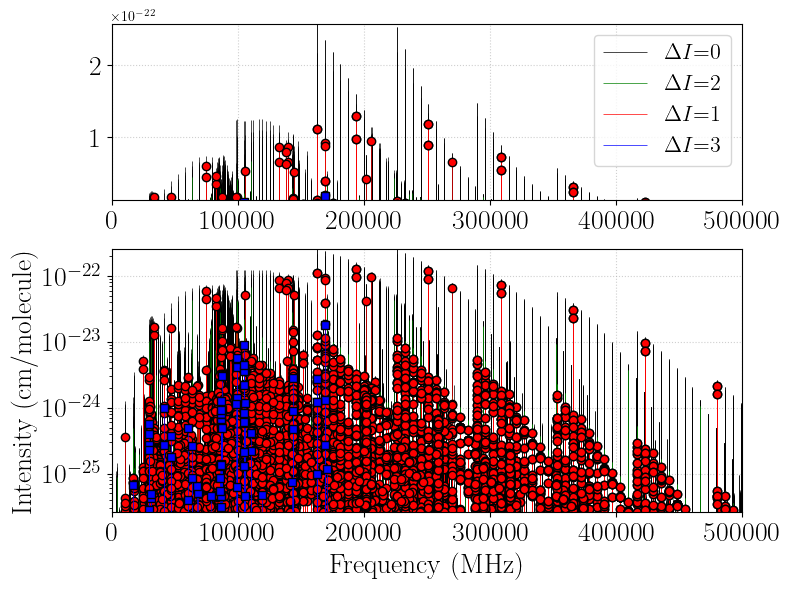

In [17]:
# frequency range (MHz)
nu1 = 0
nu2 = 500000

freq, abscoef, spin_diff, quanta = stick_spectrum(nu1, nu2)

amax = np.max(abscoef)

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(8, 6), dpi=100, gridspec_kw={"height_ratios": [1, 1.5]}
)


color = ("black", "red", "green", "blue")
linewidth = (0.5, 0.5, 0.5, 0.5)
marker = ("", "o", "", "s")

for iax, ax in enumerate((ax1, ax2)):
    for diff in (0, 2, 1, 3):
        ind = np.where((spin_diff == diff) & (abscoef >= amax * 1e-4))[0]

        if len(ind) == 0:
            continue

        ax.vlines(
            freq[ind],
            ymin=0,
            ymax=abscoef[ind],
            color=color[diff],
            linewidth=linewidth[diff],  # if iax == 0 else 1,
            label=f"$\\Delta I$={diff}",
        )

        if marker[diff]:
            ax.plot(
                freq[ind],
                abscoef[ind],
                linestyle="None",
                color=color[diff],
                mec="black",
                marker=marker[diff],  # if iax == 0 else "",
                markersize=6,
            )

for ax in (ax1, ax2):
    ax.set_xlim([nu1, nu2])
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.tick_params(axis="both", labelsize=20)

ax2.set_yscale("log")
ax1.set_ylim([np.max(abscoef) * 5e-2, np.max(abscoef)])
ax2.set_ylim([np.max(abscoef) * 1e-4, np.max(abscoef)])
ax2.set_xlabel("Frequency (cm$^{-1}$)", fontsize=20)
if hyper_states.enr_units == "mhz":
    ax2.set_xlabel("Frequency (MHz)", fontsize=20)
ax2.set_ylabel("Intensity (cm/molecule)", fontsize=20)
ax1.legend(fontsize=16, loc="upper right")
plt.tight_layout()

plt.savefig(f"ch2cl2_35_37.pdf", format="pdf", bbox_inches="tight")

Print assignments for some of the strongest nuclear spin transitions.

In [18]:
print(
    f"{'nu':>16}  {'(F1,F2)':>12}  {'(J1,J2)':>8}  {'(I1,I2)':>10}  {'(k1,k2)':>8}  {'(tau1,tau2)':>8}  {'c1²':>3}  {'c2²':>8}  {'acoef':>10}"
)

for (q1, q2), nu, acoef in zip(quanta, freq, abscoef):
    f1, j1, _, spin1, _, _, j1_, k1, tau1, _, c1 = q1
    f2, j2, _, spin2, _, _, j2_, k2, tau2, _, c2 = q2
    lab = "*" if int(abs(spin1 - spin2)) == 1 else ""

    if acoef >= amax * 1e-1 and int(abs(spin1 - spin2)) in (1, 3):
        print(
            f"{nu:16.4f}  "
            f"({float(f1):4.1f}, {float(f2):4.1f})  "
            f"({j1:2d}, {j2:2d})  "
            f"({spin1:3.1f}, {spin2:3.1f})  "
            f"({k1:2d}, {k2:2d})  "
            f"({tau1:1d}, {tau2:1d})  "
            f"{c1**2:8.4f}  "
            f"{c2**2:8.4f}  "
            f"{acoef:10.3e}"
        )

              nu       (F1,F2)   (J1,J2)     (I1,I2)   (k1,k2)  (tau1,tau2)  c1²       c2²       acoef
     168695.7725  ( 3.0,  4.0)  ( 3,  4)  (0.0, 1.0)  ( 2,  3)  (0, 1)    0.8393    0.4488   3.824e-23
     168695.7712  ( 3.0,  4.0)  ( 3,  4)  (2.0, 1.0)  ( 2,  3)  (0, 1)    0.8985    0.4488   3.828e-23
      74266.3621  ( 8.0,  9.0)  ( 7,  8)  (1.0, 2.0)  ( 0,  1)  (1, 0)    0.4234    0.4238   5.929e-23
     139783.3233  ( 8.0,  9.0)  ( 7,  8)  (1.0, 2.0)  ( 1,  2)  (1, 0)    0.4218    0.4139   8.654e-23
     132655.1748  ( 8.0,  9.0)  ( 7,  8)  (1.0, 2.0)  ( 1,  2)  (0, 1)    0.4450    0.4151   8.649e-23
     193650.6584  ( 8.0,  9.0)  ( 7,  8)  (1.0, 2.0)  ( 2,  3)  (0, 1)    0.4253    0.4162   1.293e-22
     193454.0185  ( 8.0,  9.0)  ( 7,  8)  (1.0, 2.0)  ( 2,  3)  (1, 0)    0.4266    0.4162   1.291e-22
     251067.3193  ( 8.0,  9.0)  ( 7,  8)  (1.0, 2.0)  ( 3,  4)  (1, 0)    0.4245    0.4156   1.177e-22
     251066.0280  ( 8.0,  9.0)  ( 7,  8)  (1.0, 2.0)  ( 3,  4)  (0, 1)   

max acoef: 2.5737110035909243e-22


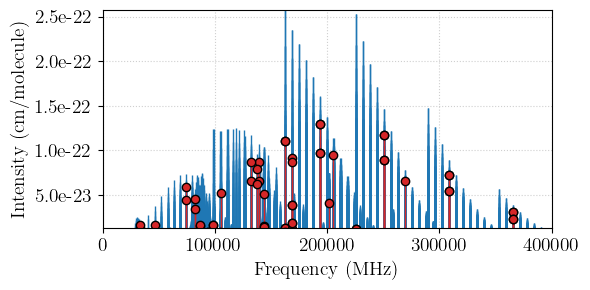

In [19]:
# frequency range (MHz)
nu1 = 0
nu2 = 400000
freq, abscoef, spin_diff, quanta = stick_spectrum(nu1, nu2)

amax = np.max(abscoef)
print("max acoef:", amax)

fig = plt.figure(figsize=(6, 3), dpi=100)

color = ("tab:blue", "tab:red", "tab:blue", "tab:red")
linewidth = (1, 1, 1, 1)
marker = ("", "o", "", "o")

for diff in (0, 2, 1, 3):
    ind = np.where((spin_diff == diff) & (abscoef >= amax * 1e-4))[0]

    if len(ind) == 0:
        continue

    plt.vlines(
        freq[ind],
        ymin=0,
        ymax=abscoef[ind],
        color=color[diff],
        linewidth=linewidth[diff],
        label=f"$\\Delta I$={diff}, {diff+2}" if diff in (0, 1) else "",
    )

    if marker[diff]:
        plt.plot(
            freq[ind],
            abscoef[ind],
            linestyle="None",
            color=color[diff],
            mec="black",
            marker=marker[diff],
            markersize=6,
        )

plt.xlim([nu1, nu2])
plt.ylim([amax * 5e-2, amax])
plt.grid(True, linestyle=":", alpha=0.6)
plt.tick_params(axis="both", labelsize=14)

plt.xlabel("Frequency (cm$^{-1}$)", fontsize=14)
if hyper_states.enr_units == "mhz":
    plt.xlabel("Frequency (MHz)", fontsize=14)
plt.ylabel("Intensity (cm/molecule)", fontsize=14)
# plt.legend(fontsize=14, loc="upper right")

formatter = FuncFormatter(lambda x, _: f"{x:.1e}")
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.tight_layout()

plt.savefig(f"ch2cl2_35_37_op_spectrum.pdf", format="pdf", bbox_inches="tight")